# Intelligent Systems 3: Probabilistic and Deep Learning
#### Exam number:

In [1]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer
import seaborn as sn
import torch
from torch import optim
import torch.nn as nn
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from skimage import io,transform
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop

In [2]:
def plot_model(model, x_test, y_test):
    prediction = model.predict(x_test)
    true_value = y_test.iloc[0]
    predicted_value = prediction[0]
    print(f"Next True value: {true_value} Next predicted value: {predicted_value} Relative Error: {abs((predicted_value-true_value)/true_value)*100}%")
    plt.figure(figsize=(10,5))
    plt.scatter(target.index, target)
    plt.plot(target.index, target, color="black")
    plt.scatter(y_test.index,prediction, color="green")
    plt.show()


# 1 Using Regression

## Data Exploration

#### Plotted Data

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df

,A,B,C,D
0,10.07,2.18,3.0,0.8
1,10.00,2.20,3.0,0.7
2,9.95,2.21,3.0,0.9
3,9.93,2.30,2.5,1.1
4,9.88,2.30,2.5,0.9
...,...,...,...,...
223,8.98,3.00,0.0,1.5
224,8.91,3.10,0.0,1.6
225,8.80,3.20,0.0,1.4
226,8.73,3.10,0.0,1.5


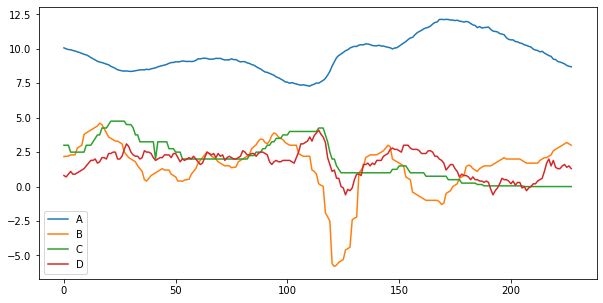

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df)
plt.legend(df.columns)
plt.show()

From plotting the data its quite east to see that there is a visible correlation between B, C and D.

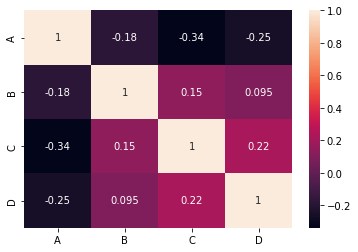

In [6]:
corrMatrix = df.diff().corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there is a relatively strong correlation between D and C but besides that there do not appear to be strongly correlated features

## Basic Regression
This is regression applied to the variables A, B, C and D(Time Lagged)

In [7]:
def preprocess_data(location,time_lag):
    df = pd.read_csv(location)
    target = df["D"].copy()
    df["D"] = target.shift(1)
    for index, columns in enumerate(["A", "B", "C", "D"]):
        for i in range(time_lag+1):
            df[f"{columns}_Lag_{i}"] = df[columns].shift(i)
    df = df.dropna()
    df.drop(["A","B","C","D"],axis=1,inplace=True)
    target = target.iloc[time_lag+1:]

    return df,target

In [8]:
df , target = preprocess_data("data.csv",0)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [10]:
model = LinearRegression()

In [11]:
model.fit(x_train,y_train)

LinearRegression()

In [12]:
r2_score(y_test, model.predict(x_test))

0.84908505442752

In [13]:
model.coef_

array([-0.01464466,  0.03385414,  0.00246456,  0.94113835])

Next True value: 0.3 Next predicted value: 0.3930695504934571 Relative Error: 31.02318349781904%


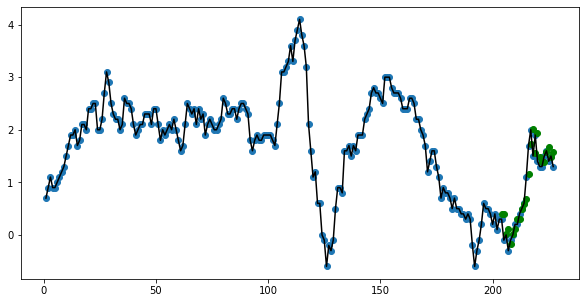

In [14]:
plot_model(model,x_test,y_test)

### Time Laggged Linear Regression

In [15]:
df, target = preprocess_data("data.csv",4)

The code cell below adds time lag to the dataset. By default the shift function deletes data, but there are options to fill the deleted data wih any given value. At first I attempted to duplicate the first know value but this did not improve accuracy.

Data is split into a 2 sets, the training set and the testing set

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [17]:
model = LinearRegression()

In [18]:
model.fit(x_train,y_train)

LinearRegression()

In [19]:
r2_score(y_test, model.predict(x_test))

0.8499773374753239

Next True value: 0.3 Next predicted value: 0.3034641842679867 Relative Error: 1.1547280893289085%


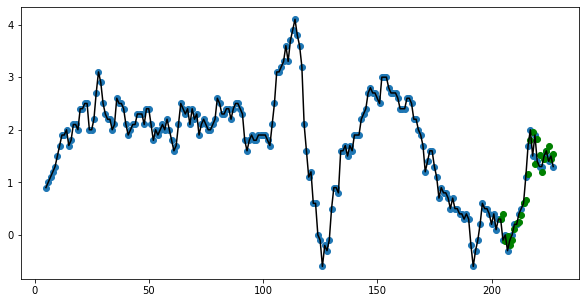

In [20]:
plot_model(model,x_test,y_test)

### Regularisation

Regularisation is the process of adding a penalty function to model. In the real world its very rare that data exists with no noise, so regularisation is a tool that can be used to decrease the likelyhood of the model overfitting and therefore generalising better


In [21]:
df, target = preprocess_data("data.csv",0)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=25)

In [23]:
myalphas = np.logspace(-6, 6, 13)

#### Ridge Regression
Ridge Regression is most effective when the features are highly correlated.

In [24]:
model = RidgeCV()

In [25]:
ridge_reg = model.fit(x_train,y_train)

In [26]:
r2_score(y_test, ridge_reg.predict(x_test))

0.8528251571656325

Next True value: 0.3 Next predicted value: 0.20060867323530684 Relative Error: 33.130442254897716%


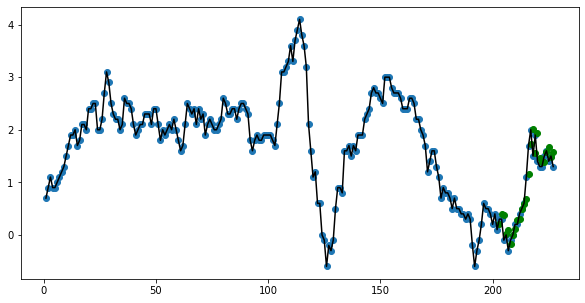

In [27]:
plot_model(ridge_reg,x_test,y_test)

#### Lasso Regression

In [28]:
model = LassoCV(alphas=myalphas)

In [29]:
lasso_reg = model.fit(x_train,y_train)

In [30]:
r2_score(y_test, lasso_reg.predict(x_test))

0.8536675982744497

Next True value: 0.3 Next predicted value: 0.21511301087083884 Relative Error: 28.29566304305372%


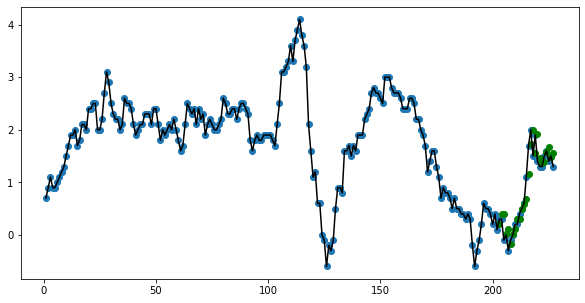

In [31]:
plot_model(lasso_reg,x_test,y_test)

#### Elastic Net Regression

In [32]:
model = ElasticNetCV()

In [33]:
elastic_reg = model.fit(x_train, y_train)

In [34]:
r2_score(y_test, elastic_reg.predict(x_test))

0.853340628031713

Next True value: 0.3 Next predicted value: 0.2067323008920997 Relative Error: 31.089233035966764%


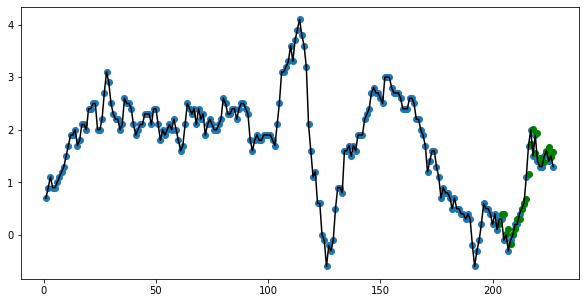

In [35]:
plot_model(elastic_reg, x_test, y_test)

## Polynomial Regression

In [36]:
df, target = preprocess_data("data.csv",0)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=60)

In [38]:
model = make_pipeline(PolynomialFeatures(3),RidgeCV())

In [39]:
poly_regression = model.fit(x_train, y_train)

In [40]:
r2_score(y_test, poly_regression.predict(x_test))

0.7175258293094327

Next True value: 2.0 Next predicted value: 2.2480660263600143 Relative Error: 12.403301318000715%


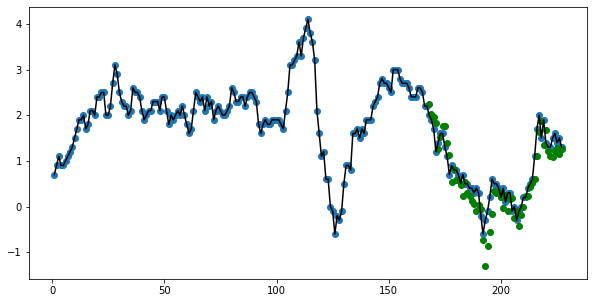

In [41]:
plot_model(poly_regression,x_test,y_test)

## Piecewise Regression

In [42]:
df, target = preprocess_data("data.csv",0)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(df.tail(100),target.tail(100),shuffle=False,test_size=10)

In [44]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [45]:
def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

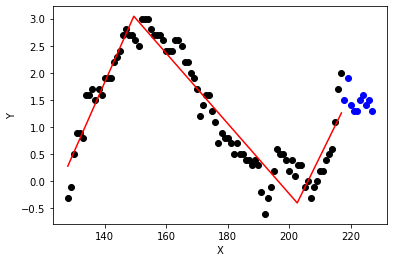

In [46]:
plt.plot( x_train.index, y_train, 'ok' );
plt.scatter(y_test.index, y_test,color="blue")
initialBreakpoints = [140,200]
#Try also with 3 breakpoints, e.g. [3,5,6]
model_prediction = SegmentedLinearReg( x_train.index, y_train, initialBreakpoints )
plt.plot( *model_prediction, '-r' );
plt.xlabel('X'); plt.ylabel('Y');

## Spline Interpolation

In [47]:
df , target = preprocess_data("data.csv",0)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=40)

In [49]:
spline_model = make_pipeline(SplineTransformer(n_knots=3,degree=3),LinearRegression())

In [50]:
spline_model.fit(x_train,y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=3)),
                ('linearregression', LinearRegression())])

In [51]:
r2_score(y_test, spline_model.predict(x_test))

0.7624387873749938

Next True value: 0.3 Next predicted value: 0.424072265625 Relative Error: 41.35742187500001%


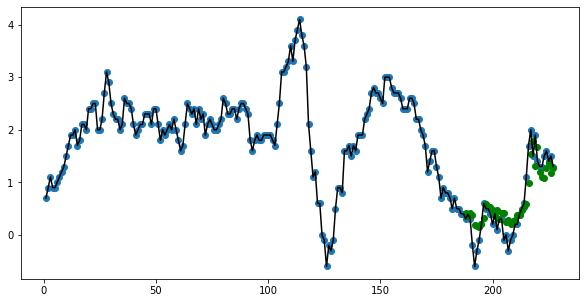

In [52]:
plot_model(spline_model,x_test, y_test)

## Final Solution - Test Data Demonstration

For my final soloution, I am attempting to combine the most effective techniques (in terms of r_2)

In [53]:
myalphas = np.logspace(-6, 6, 13)

In [54]:
df,target = preprocess_data("data.csv",4)

In [55]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)

In [56]:
df

,A_Lag_0,A_Lag_1,A_Lag_2,A_Lag_3,A_Lag_4,B_Lag_0,B_Lag_1,B_Lag_2,B_Lag_3,B_Lag_4,C_Lag_0,C_Lag_1,C_Lag_2,C_Lag_3,C_Lag_4,D_Lag_0,D_Lag_1,D_Lag_2,D_Lag_3,D_Lag_4
0,0.191786,0.219065,0.254117,0.265907,0.301316,0.459978,0.456923,0.459330,0.415926,0.413405,0.425665,0.419415,0.413152,0.747967,0.740693,-0.883562,-0.670015,-0.877260,-1.080784,-0.970532
1,0.145002,0.187845,0.215057,0.250271,0.262209,0.711627,0.462064,0.459330,0.462322,0.418567,0.425665,0.419415,0.413152,0.404976,0.740693,-0.883562,-0.880901,-0.666680,-0.870750,-1.075340
2,0.106015,0.141015,0.183809,0.211183,0.246566,0.762984,0.713971,0.464477,0.462322,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.778027,-0.880901,-0.877260,-0.660715,-0.865724
3,0.059232,0.101990,0.136937,0.179912,0.207459,0.814341,0.765381,0.716693,0.467477,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.672491,-0.775458,-0.877260,-0.870750,-0.656108
4,0.004650,0.055160,0.097877,0.133006,0.176174,1.214925,0.816790,0.768165,0.720080,0.470188,0.425665,0.419415,0.413152,0.404976,0.396794,-0.566956,-0.670015,-0.771970,-0.870750,-0.865724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,-0.478783,-0.436556,-0.409901,-0.304785,-0.285287,0.814341,0.765381,0.716693,0.668528,0.619888,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.461421,-0.459128,-0.350810,0.179424,-0.236876
219,-0.533364,-0.483386,-0.441149,-0.414233,-0.308751,0.865698,0.816790,0.768165,0.720080,0.671509,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.250350,-0.459128,-0.456100,-0.345663,0.182357
220,-0.619134,-0.538021,-0.488021,-0.445503,-0.418251,0.917055,0.868200,0.819638,0.771631,0.723129,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.144815,-0.248241,-0.456100,-0.450680,-0.341684
221,-0.673715,-0.623876,-0.542705,-0.492410,-0.449536,0.865698,0.919609,0.871111,0.823182,0.774750,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.355886,-0.142798,-0.245520,-0.450680,-0.446492


In [57]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [58]:
model = make_pipeline(RidgeCV())

In [59]:
model.fit(x_train,y_train)

Pipeline(steps=[('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [60]:
r2_score(y_test, model.predict(x_test))

0.8556494922440849

Next True value: 0.3 Next predicted value: 0.3072181851480249 Relative Error: 2.406061716008305%


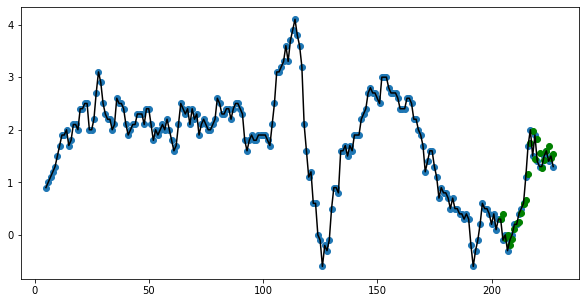

In [61]:
plot_model(model,x_test,y_test)

## Final Solution - Markers Evaluation

Here is my final solution to be executed with the unseen data set, I am assuming the dataset is a csv file in the same directory as this notebook

 R_2 score: 0.9430152250105639
Next True value: 0.9 Next predicted value: 0.9581173915030603 Relative Error: 6.457487944784475%


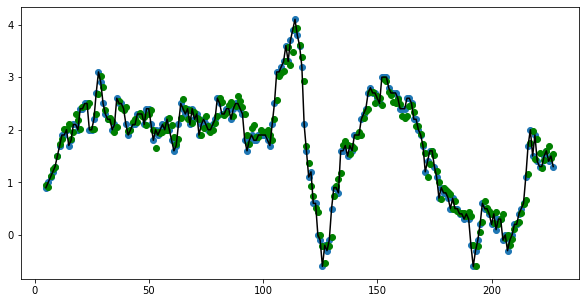

In [62]:
df, target = preprocess_data("unseen.csv",4)
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)
print(f" R_2 score: {r2_score(target, model.predict(df))}")
plot_model(model,df,target)

In the plot above, the green points are generated by my model, where are the blue points represent the data in unseen.csv

# 2. Descriptive statistics and dimensionality reduction

In [63]:
pca = PCA(n_components=12,svd_solver = 'full')

In [64]:
pca.fit(df)

PCA(n_components=12, svd_solver='full')

In [65]:
pca_df = pd.DataFrame(pca.fit_transform(df))

In [66]:
df.var(axis=0).sort_values(ascending=False)

A_Lag_3    1.004505
B_Lag_3    1.004505
B_Lag_2    1.004505
A_Lag_2    1.004505
D_Lag_1    1.004505
C_Lag_0    1.004505
A_Lag_1    1.004505
A_Lag_0    1.004505
B_Lag_1    1.004505
C_Lag_1    1.004505
A_Lag_4    1.004505
D_Lag_2    1.004505
D_Lag_3    1.004505
C_Lag_4    1.004505
B_Lag_4    1.004505
C_Lag_2    1.004505
C_Lag_3    1.004505
D_Lag_4    1.004505
B_Lag_0    1.004505
D_Lag_0    1.004505
dtype: float64

In [67]:
print(f"Total Variance for normal data: {pd.Series(df.var(axis=0)).sum()}")

Total Variance for normal data: 20.09009009009009


In [68]:
print(f"Total Variance for PCA data: {pca_df.var(axis=0).sum()}")

Total Variance for PCA data: 20.057175497257592


## 1.2 PCA Calulation

### Steps
1. Centre Matrix
2. Calculate the covariance matrix
3. Calculate eigenvectors & eigenvalues of the covariance matrix
4. Select the first n eigenvectors


In [69]:
mean_df = np.mean(df.T,axis=1)

In [70]:
centre =df - mean_df

In [71]:
covariance = np.cov(df.T)

In [72]:
centre

,A_Lag_0,A_Lag_1,A_Lag_2,A_Lag_3,A_Lag_4,B_Lag_0,B_Lag_1,B_Lag_2,B_Lag_3,B_Lag_4,C_Lag_0,C_Lag_1,C_Lag_2,C_Lag_3,C_Lag_4,D_Lag_0,D_Lag_1,D_Lag_2,D_Lag_3,D_Lag_4
0,0.191786,0.219065,0.254117,0.265907,0.301316,0.459978,0.456923,0.459330,0.415926,0.413405,0.425665,0.419415,0.413152,0.747967,0.740693,-0.883562,-0.670015,-0.877260,-1.080784,-0.970532
1,0.145002,0.187845,0.215057,0.250271,0.262209,0.711627,0.462064,0.459330,0.462322,0.418567,0.425665,0.419415,0.413152,0.404976,0.740693,-0.883562,-0.880901,-0.666680,-0.870750,-1.075340
2,0.106015,0.141015,0.183809,0.211183,0.246566,0.762984,0.713971,0.464477,0.462322,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.778027,-0.880901,-0.877260,-0.660715,-0.865724
3,0.059232,0.101990,0.136937,0.179912,0.207459,0.814341,0.765381,0.716693,0.467477,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.672491,-0.775458,-0.877260,-0.870750,-0.656108
4,0.004650,0.055160,0.097877,0.133006,0.176174,1.214925,0.816790,0.768165,0.720080,0.470188,0.425665,0.419415,0.413152,0.404976,0.396794,-0.566956,-0.670015,-0.771970,-0.870750,-0.865724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,-0.478783,-0.436556,-0.409901,-0.304785,-0.285287,0.814341,0.765381,0.716693,0.668528,0.619888,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.461421,-0.459128,-0.350810,0.179424,-0.236876
219,-0.533364,-0.483386,-0.441149,-0.414233,-0.308751,0.865698,0.816790,0.768165,0.720080,0.671509,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.250350,-0.459128,-0.456100,-0.345663,0.182357
220,-0.619134,-0.538021,-0.488021,-0.445503,-0.418251,0.917055,0.868200,0.819638,0.771631,0.723129,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.144815,-0.248241,-0.456100,-0.450680,-0.341684
221,-0.673715,-0.623876,-0.542705,-0.492410,-0.449536,0.865698,0.919609,0.871111,0.823182,0.774750,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.355886,-0.142798,-0.245520,-0.450680,-0.446492


In [73]:
covariance

array([[ 1.0045045 ,  1.00217627,  0.99657093,  0.98763024,  0.97580306,
        -0.29348531, -0.33681395, -0.37605901, -0.41062819, -0.44188582,
        -0.78185756, -0.78171849, -0.77882595, -0.7721702 , -0.76284896,
        -0.48545908, -0.46661304, -0.44232609, -0.41317847, -0.38062739],
       [ 1.00217627,  1.0045045 ,  1.0021699 ,  0.99656296,  0.98764136,
        -0.24501736, -0.29104995, -0.33436017, -0.37367763, -0.40841024,
        -0.78592329, -0.78881278, -0.78878019, -0.78494703, -0.77839145,
        -0.50261289, -0.48696963, -0.4683799 , -0.44312924, -0.41448253],
       [ 0.99657093,  1.0021699 ,  1.0045045 ,  1.00217144,  0.99658626,
        -0.19412575, -0.24245741, -0.28846767, -0.33185389, -0.37134638,
        -0.78710466, -0.79264628, -0.79565544, -0.79463265, -0.79091135,
        -0.5151262 , -0.50416276, -0.48878997, -0.46925636, -0.44449466],
       [ 0.98763024,  0.99656296,  1.00217144,  1.0045045 ,  1.00218086,
        -0.14157696, -0.19159693, -0.23990526, -

In [74]:
eigenvalues,eigenvectors = np.linalg.eig(covariance)

In [75]:
idx = eigenvalues.argsort()[::-1]

In [76]:
eigenvalues = eigenvalues[idx]

In [77]:
eigenvectors = eigenvectors[:,idx]

In [78]:
    principals = eigenvectors.T.dot(centre.T)

In [79]:
principals.T[:,0:4]

array([[-2.69559139e-01,  1.46975449e+00,  1.22721934e+00,
        -1.72292015e+00],
       [-2.65987075e-01,  1.60248359e+00,  1.17665546e+00,
        -1.55509487e+00],
       [-2.10979648e-01,  1.72297419e+00,  1.05208547e+00,
        -1.37273005e+00],
       [-7.24210965e-02,  1.84527145e+00,  9.97180915e-01,
        -1.29906630e+00],
       [ 9.46331951e-02,  2.17389635e+00,  9.37102433e-01,
        -1.22528180e+00],
       [ 4.34578745e-01,  2.44583416e+00,  7.81535165e-01,
        -1.23618329e+00],
       [ 7.99301571e-01,  2.60067277e+00,  5.81155590e-01,
        -1.22237523e+00],
       [ 1.20551019e+00,  2.72947246e+00,  3.50164987e-01,
        -1.17736074e+00],
       [ 1.69090953e+00,  2.82296195e+00,  1.00234981e-01,
        -1.16858434e+00],
       [ 2.14673267e+00,  2.77131142e+00, -4.40192483e-02,
        -1.23799465e+00],
       [ 2.56372162e+00,  2.73011022e+00, -1.91534430e-01,
        -1.24620853e+00],
       [ 2.86432735e+00,  2.75368975e+00, -1.63641081e-01,
      

In [80]:
pca.explained_variance_ratio_

array([0.58708917, 0.22188902, 0.11881194, 0.04515415, 0.01261772,
       0.00531862, 0.00251696, 0.00133765, 0.00113849, 0.00096917,
       0.00081245, 0.00070631])

In [81]:
pca.components_

array([[-0.25649291, -0.2584114 , -0.25902441, -0.25832516, -0.2563646 ,
         0.08519269,  0.10544687,  0.12370482,  0.13971643,  0.15285667,
         0.27026571,  0.27129298,  0.27075614,  0.26835717,  0.26441902,
         0.22378882,  0.22257285,  0.21763165,  0.20888538,  0.19702531],
       [ 0.03880159,  0.01396075, -0.01158513, -0.03753092, -0.06338219,
        -0.43764403, -0.43166245, -0.41738978, -0.39693824, -0.36939362,
         0.00995689,  0.03033433,  0.05179448,  0.07362589,  0.09567832,
         0.08329501,  0.11760998,  0.15332021,  0.18834374,  0.220502  ],
       [-0.25537655, -0.25090706, -0.24796458, -0.24637547, -0.24588384,
        -0.06311662, -0.09296325, -0.11649179, -0.13364485, -0.14152703,
         0.07866502,  0.07918581,  0.08272866,  0.08995528,  0.09983465,
        -0.33831527, -0.35507117, -0.35744249, -0.34410624, -0.31784702],
       [-0.26335492, -0.26672914, -0.26818376, -0.2678872 , -0.26634737,
        -0.02553622, -0.010022  ,  0.00429962,  

# 3. Predicting light source direction from face images with a CNN
For this question, I am approaching the problem as a classification problem. The main reason I am doing this is because It is known that there are 64 possible classes for the data. This means that even though one of the camera angles may not be correct, if the error is low in the classification. I can be confident that whatever group I classify the point as, it will be in close proximity to the true value

In [82]:
df = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
le = LabelEncoder()

In [84]:
def show_face(image, camera_position):
    """Show image with landmarks"""
    plt.title(camera_position)
    plt.imshow(image,cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated

Since I am taking the approach of classification. I first create a string that is a concattenation of all the values of each compnent of the vector. I add a comma between them so I can use them to delimit the components after the classification. Finally I use a label encoder to transform these in 64 integers, representing each camera location

In [85]:
def encode_dataframe(df):
    df[4] = df[1].astype(str) + "," + df[2].astype(str) +","+ df[3].astype(str)
    df[4]  = le.fit_transform(df[4])
    return df

In the code cell below I have created a FaceDataset class that inherits from the pytorch library. It takes in the csv file an the image directory as arguments.

I read the image and resize it to a 160x160 image, I wanted to use an image as large as possible so features are as pronoucned as possible allowing filters to detect them more strongly.

In [86]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(160,160))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

Here I load in the labels for the data and then pass them through my encoding function.The outputted dataframe shows the encodings of the various camera positions

In [87]:
df2 = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [88]:
encode_dataframe(df2).sort_values(by=4)

,0,1,2,3,4
249,0250.jpg,-0.087156,-0.996195,0.0,0
937,0938.jpg,-0.087156,-0.996195,0.0,0
1703,1704.jpg,-0.087156,-0.996195,0.0,0
313,0314.jpg,-0.087156,-0.996195,0.0,0
1127,1128.jpg,-0.087156,-0.996195,0.0,0
...,...,...,...,...,...
1518,1519.jpg,1.000000,0.000000,0.0,63
1070,1071.jpg,1.000000,0.000000,0.0,63
1134,1135.jpg,1.000000,0.000000,0.0,63
1582,1583.jpg,1.000000,0.000000,0.0,63


Here I'm using a batch size of 32. The dataset isn't too large so I could use a smaller batch size, but I was happy with the performance of my model so I kept it as is

In [89]:
batch_size=32

In [90]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train')

In [91]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                           image_dir='deeplearning/validate')

In [92]:
train_split, validation_split = random_split(train_dataset,[1470,368])

In [93]:
train_dataloader = DataLoader(train_split, batch_size=batch_size,
                              shuffle=True, num_workers=0)

In [94]:
validation_dataloader = DataLoader(validation_split, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [95]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=0)

In [96]:
def label_decode(label):
    temp = le.inverse_transform(label)
    temp = temp.reshape(1,-1).flatten()
    temp = temp[0].split(",")

    return torch.tensor(np.array(temp).astype(float))

In [97]:
def angular_error(output,label):
    total_error  = 0
    for output_val,predic_val in zip(map(label_decode,[ [x] for x in output]),map(label_decode,[[x] for x in label])):
        total_error += torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(output_val,predic_val))))
    return torch.rad2deg(total_error)

The neural network is composed of 3 blocks of Convolutional, Batch Norm and Maxpool layers followed by a MLP.

A convolutional neural network is used because: "Insert why CNN's are good"
Batchnorm is used to make neural networks stable. The input data of the next layer is normalsied, this means that the gradient decent algorithm will converge faster as the loss function is smoothed. It also debated that Batch Normalisation reduces internal covariant shift.

In [98]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 80 x 80 after this maxpool
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.MaxPool2d(kernel_size=2, stride=4), # B x 12 x20 x 20,
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),# B x 48 x 18x 18,
            nn.BatchNorm2d(24),
            nn.ReLU()



        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=24*18*18,out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=64)
        )

    def forward(self, x):
        residual = x
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 10
        return x

model = CNN()
model.to(device)
loss_func = nn.CrossEntropyLoss()

In [99]:
num_epochs = 25
learning_rate =0.01

In [100]:


# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
images,labels, _= next(iter(train_dataloader))
# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataset)/batch_size)
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
for epoch in range(num_epochs):

    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    angle_error = 0
    for i, (inputs, labels,_) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        pred_y = torch.argmax(output, 1)
        angle_error += angular_error(pred_y.to("cpu"),labels.to("cpu"))
        correct += (pred_y == labels).sum()
        total += float(labels.size(0))
        total_loss += loss*images.shape[0]
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataset)
    training_losses.append(total_loss.item())
    training_accuracies.append(correct/total)
    print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))
    print(f"Mean Angular Error ={angle_error/len(train_dataset)}")

    # One epoch on the validation set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels,_ in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output,labels)
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels).sum()
            total += float(labels.size(0))
            total_loss += loss*images.shape[0]
        validation_accuracy = correct/total
    total_loss /= len(validation_split)
    validation_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    validation_accuracies.append(validation_accuracy)
    print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,validation_accuracy))

Train accuracy over epoch 1: 0.2571
Mean Angular Error =19.134455905666957
Test accuracy at epoch 1: 0.4973
Train accuracy over epoch 2: 0.5558
Mean Angular Error =8.056141197438048
Test accuracy at epoch 2: 0.6250
Train accuracy over epoch 3: 0.6762
Mean Angular Error =5.895687945248761
Test accuracy at epoch 3: 0.6196
Train accuracy over epoch 4: 0.7354
Mean Angular Error =4.1847671875579575
Test accuracy at epoch 4: 0.7935
Train accuracy over epoch 5: 0.8088
Mean Angular Error =3.2467984483444017
Test accuracy at epoch 5: 0.8424
Train accuracy over epoch 6: 0.8653
Mean Angular Error =2.274865068328958
Test accuracy at epoch 6: 0.8913
Train accuracy over epoch 7: 0.8707
Mean Angular Error =2.1293178525264955
Test accuracy at epoch 7: 0.8886
Train accuracy over epoch 8: 0.8993
Mean Angular Error =1.8270086135839962
Test accuracy at epoch 8: 0.8043
Train accuracy over epoch 9: 0.8980
Mean Angular Error =1.878965309866201
Test accuracy at epoch 9: 0.8777
Train accuracy over epoch 10: 0.

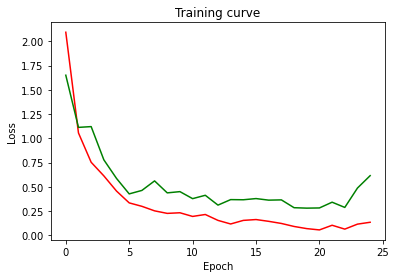

In [101]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(validation_losses)),validation_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

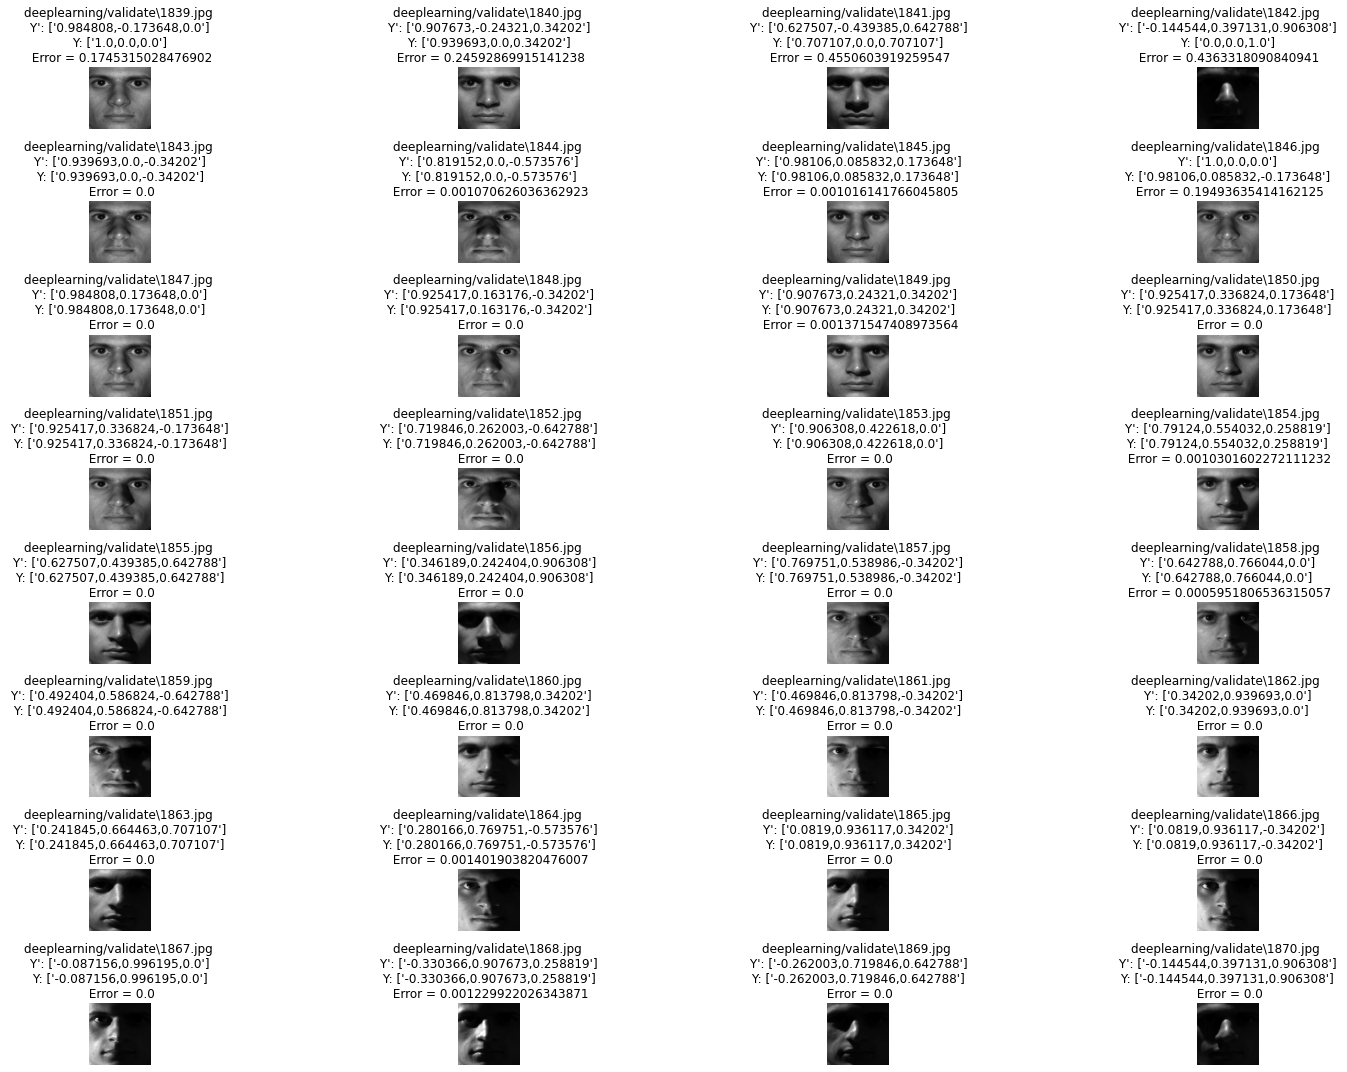

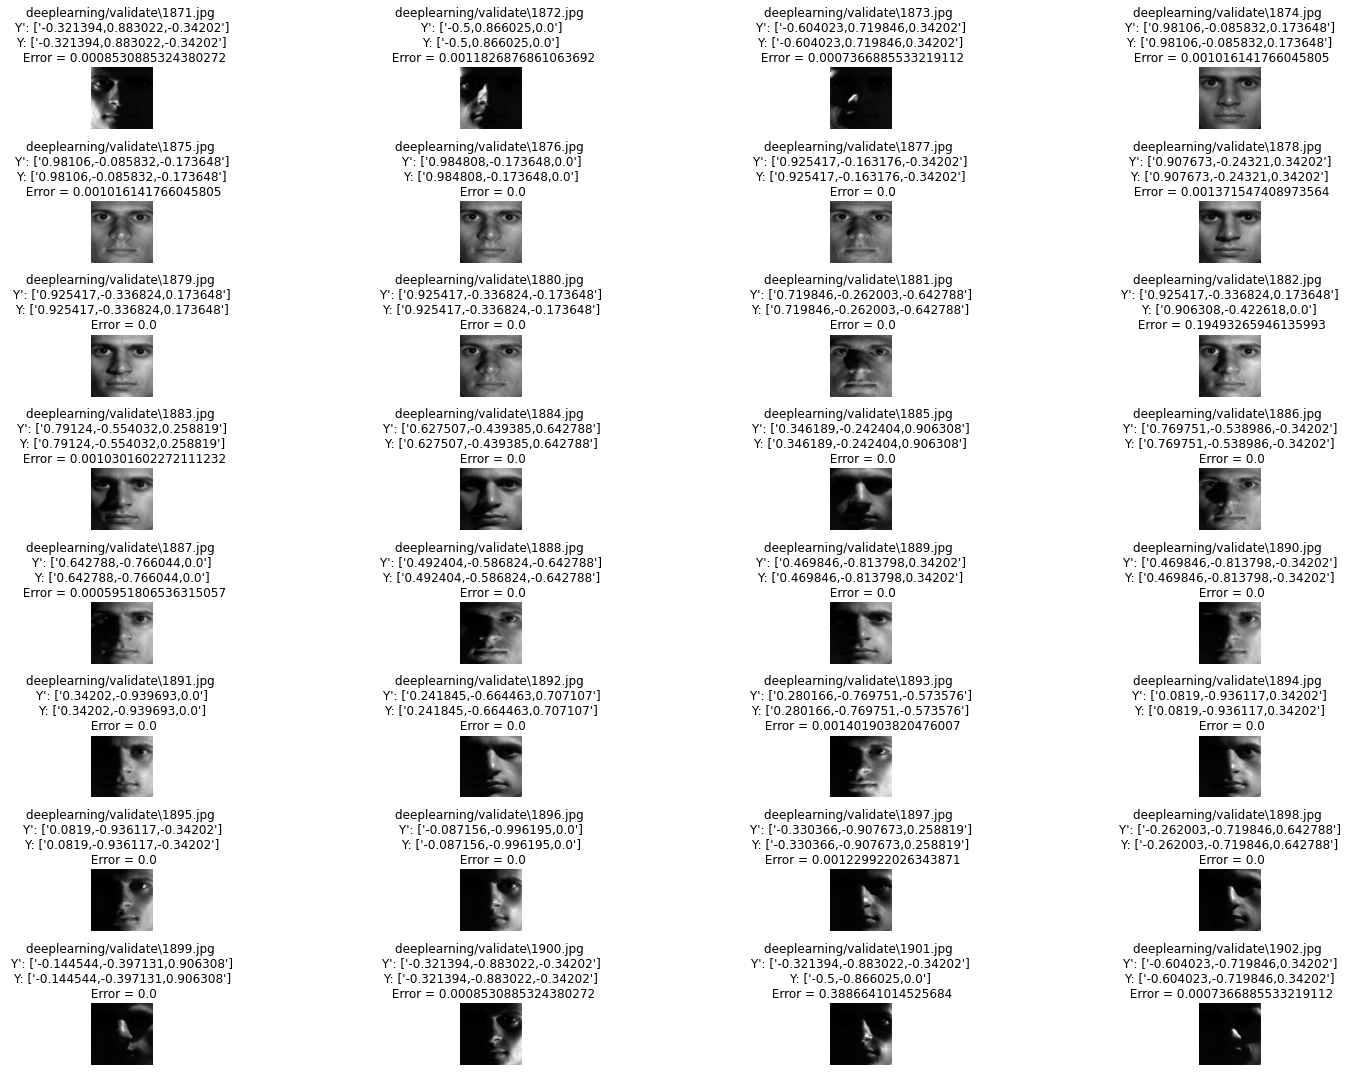

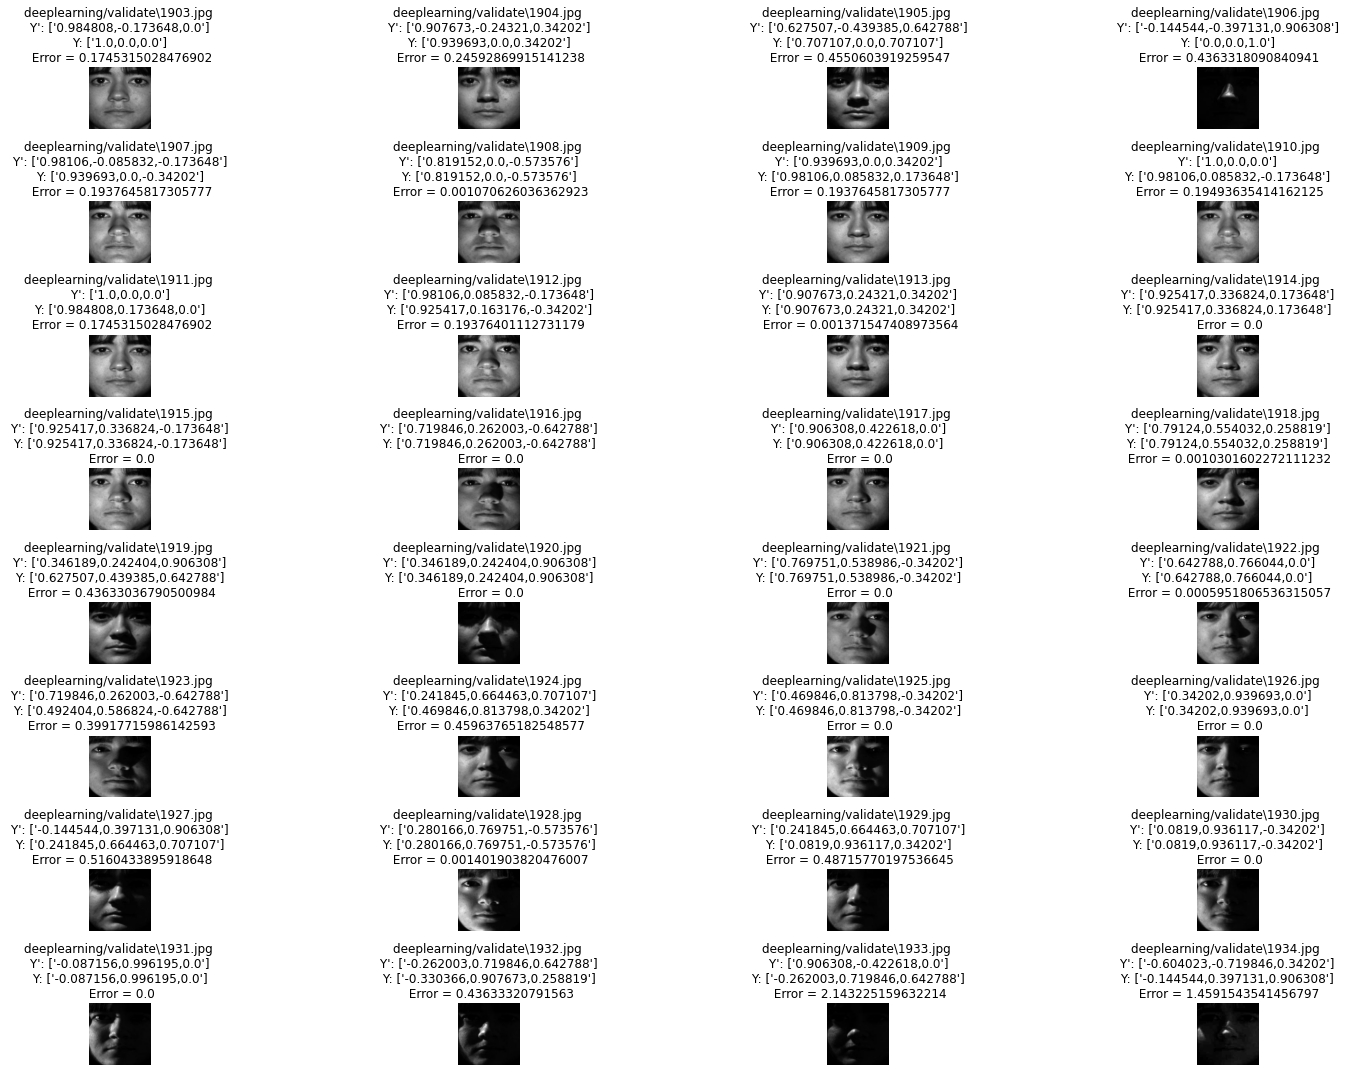

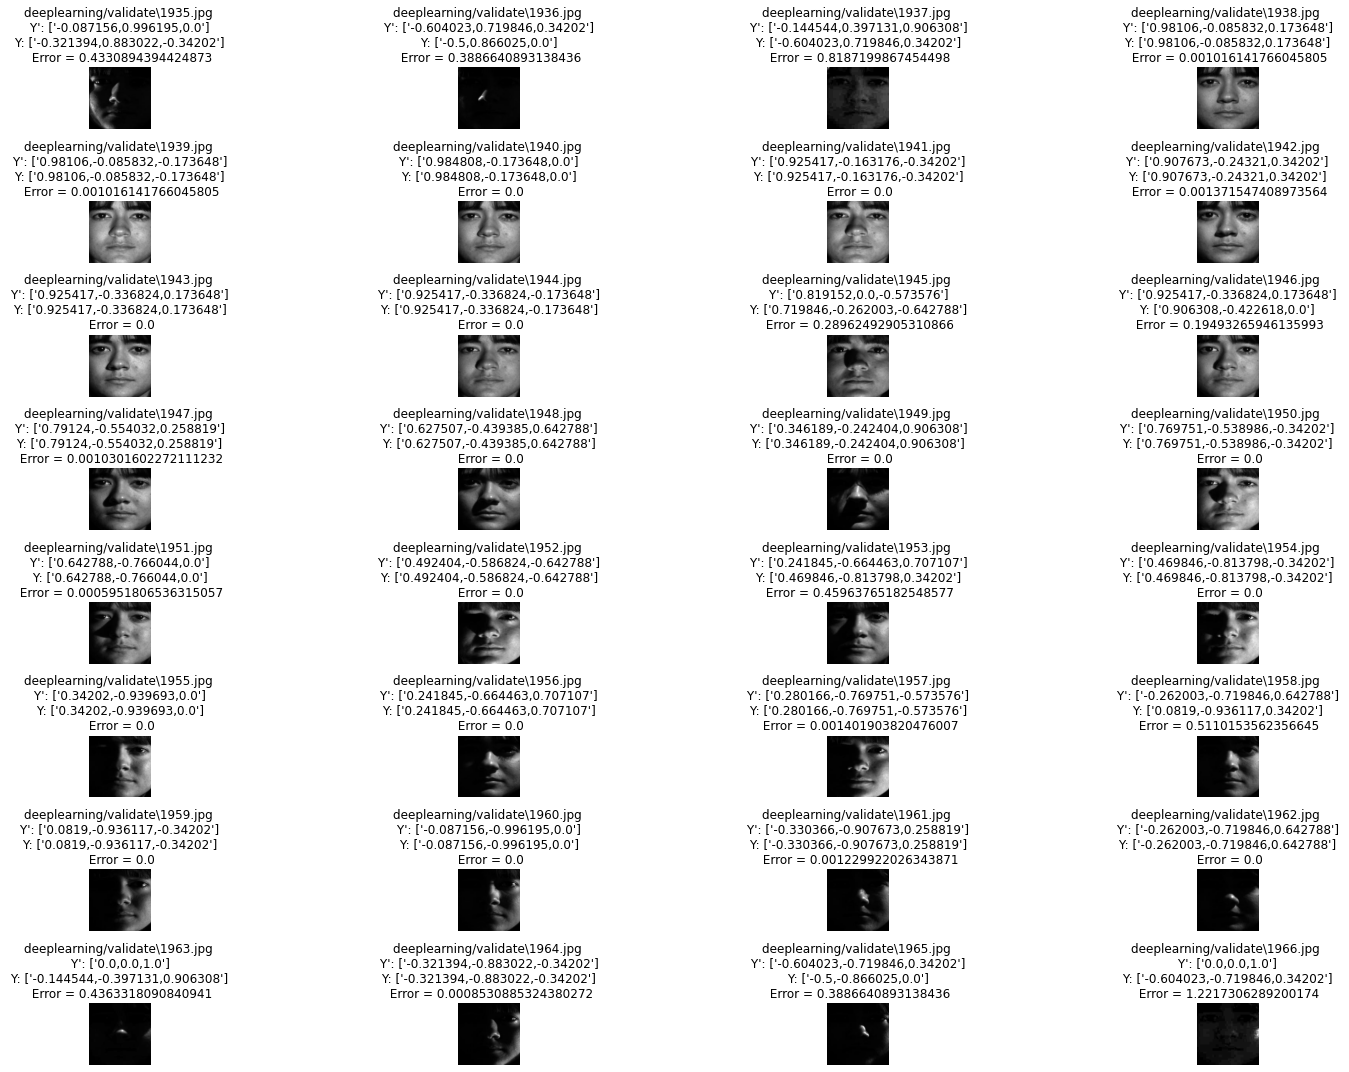

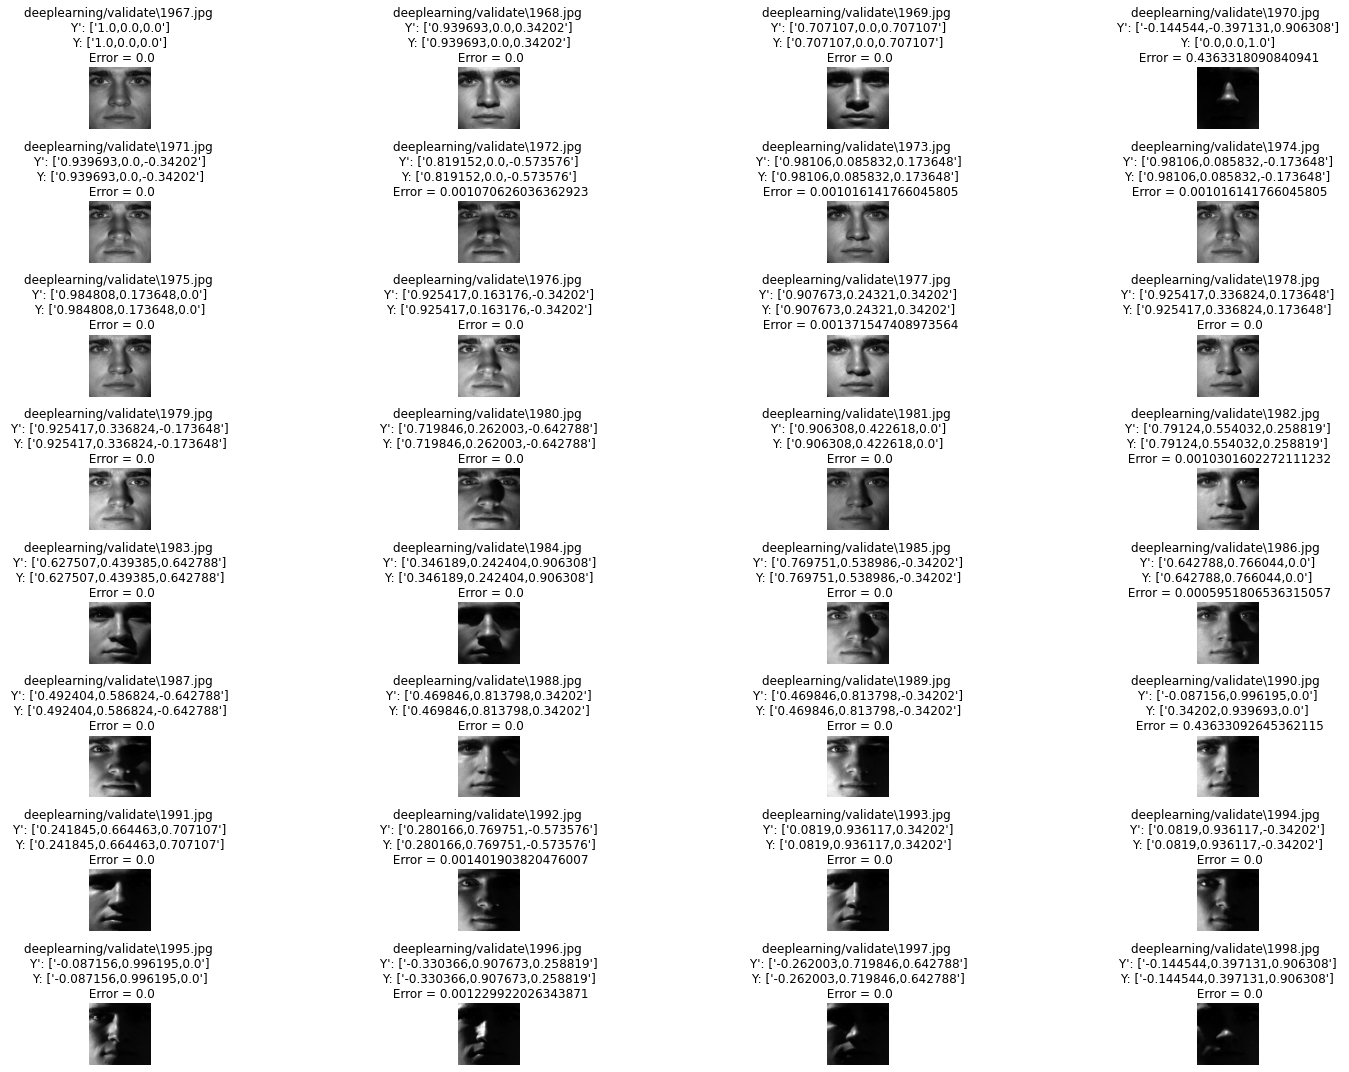

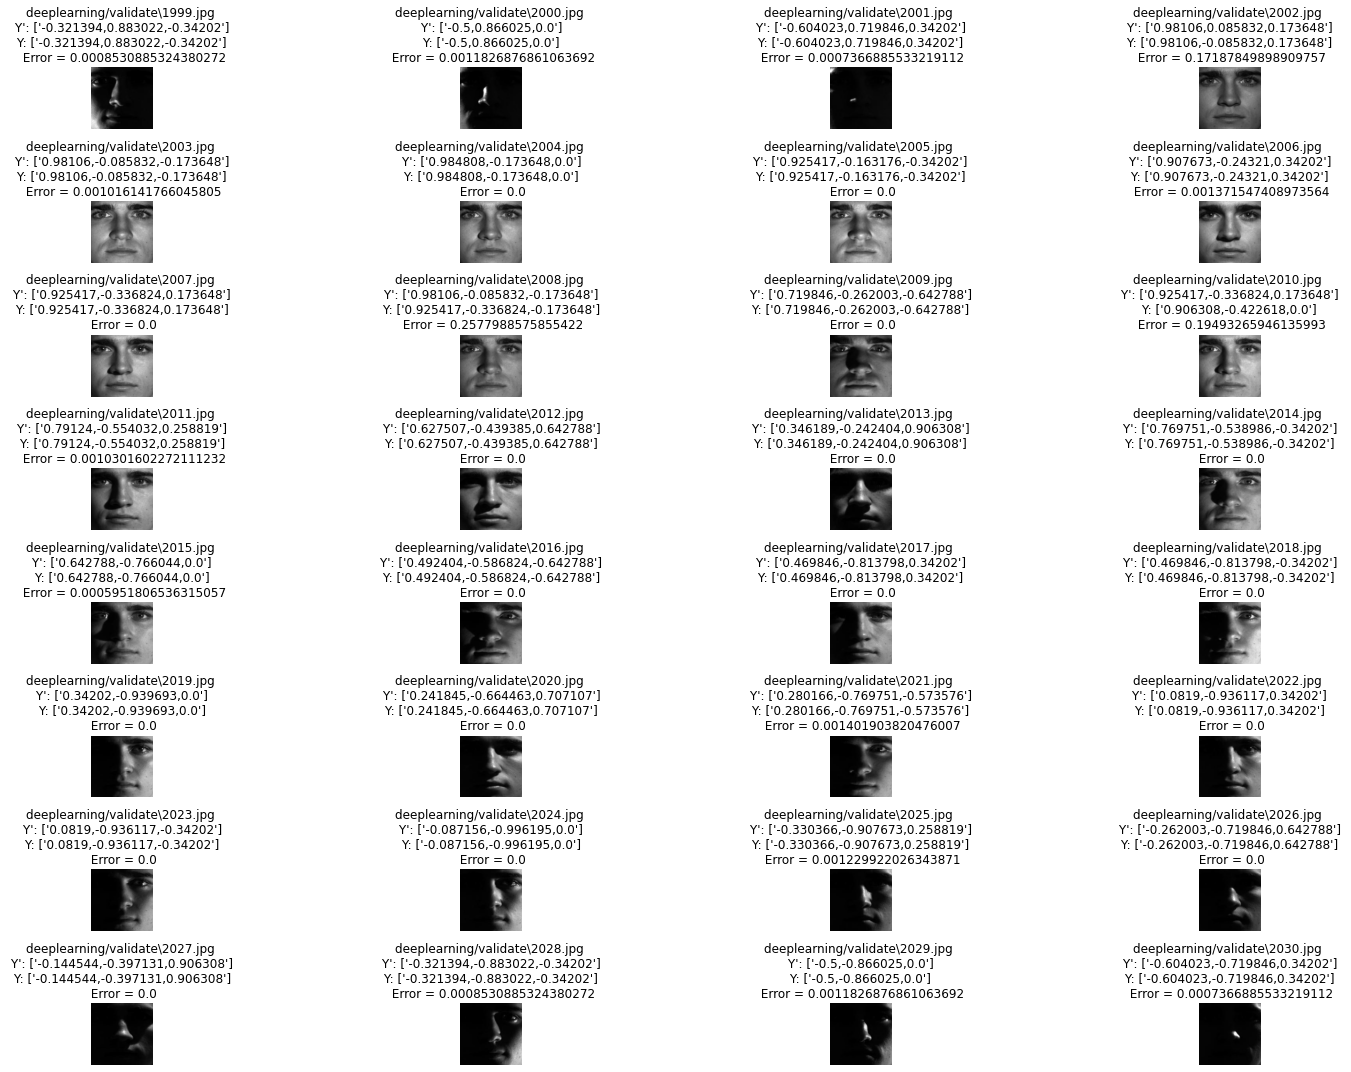

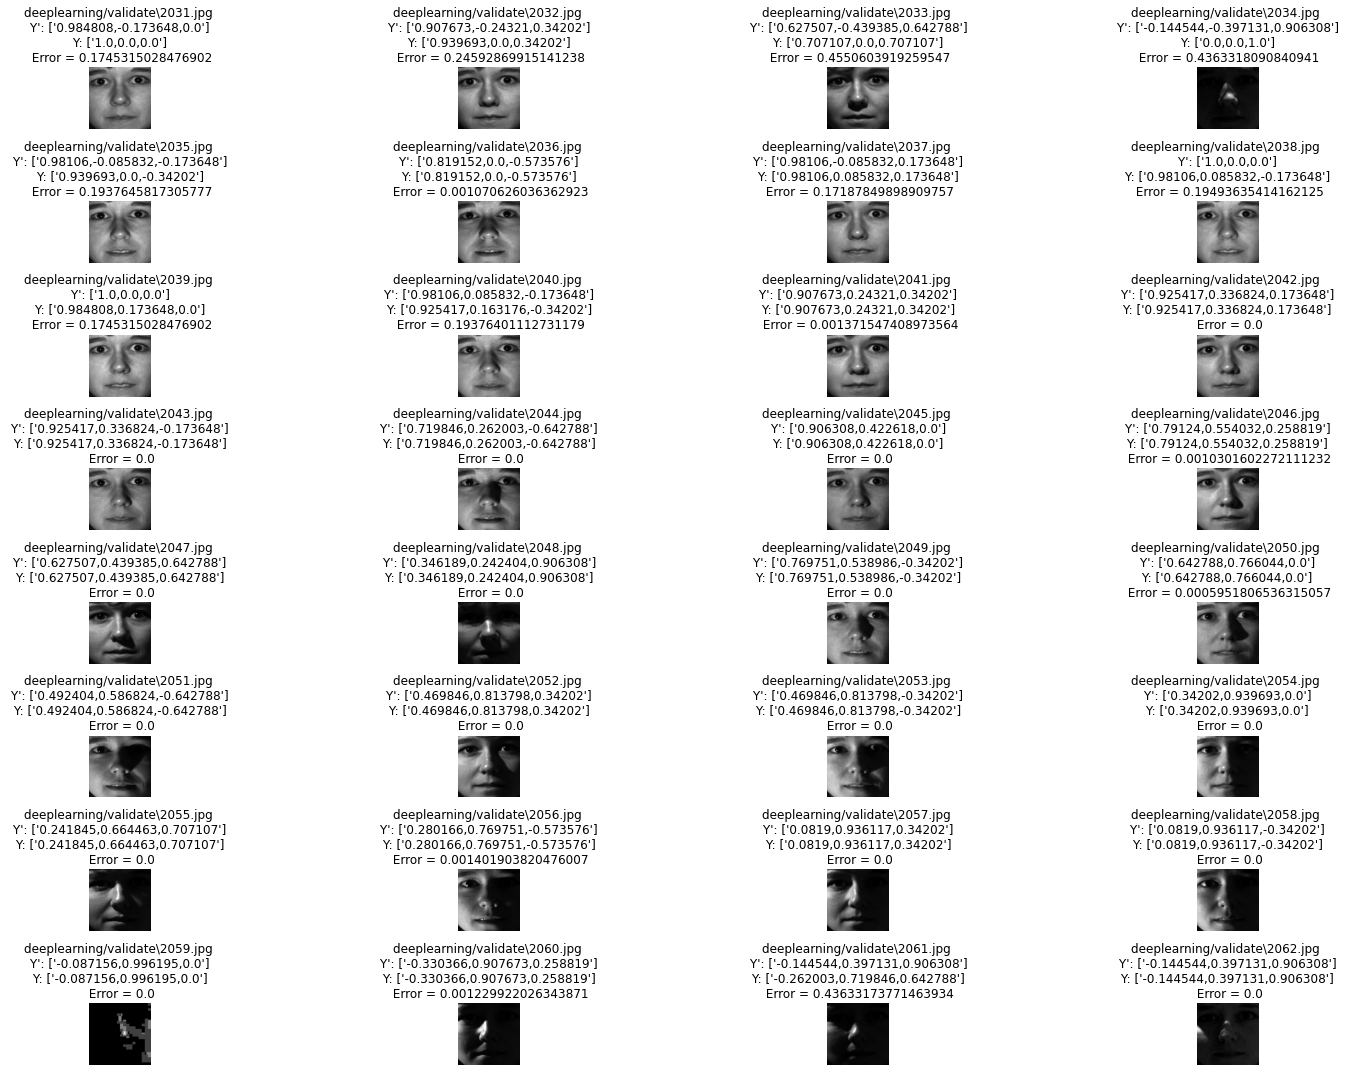

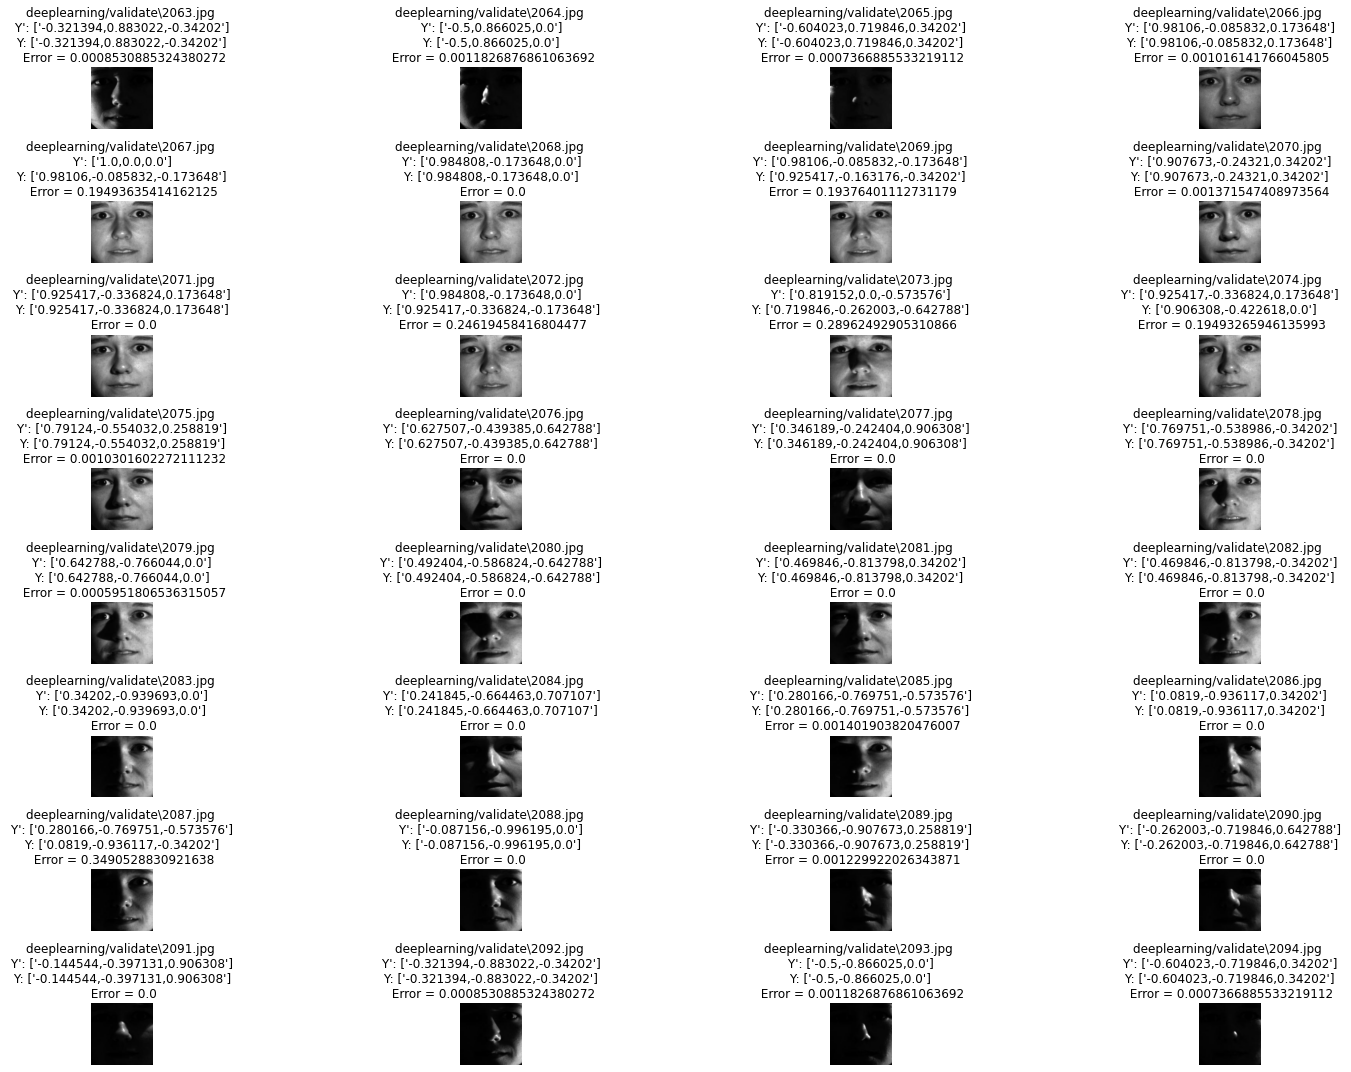

 Mean Angle Error is :0.08


In [102]:
angle_errors = []
for index, (images, labels,image_names) in enumerate(test_dataloader):
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    pred_y = torch.argmax(output, 1)
    figure = plt.figure(figsize=(30, 15))
    for i in range(32):
        figure.add_subplot(8, 4, i+1)
        error = torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(label_decode([pred_y[i].item()]),label_decode([labels[i].item()])))))
        angle_errors.append(error)
        plt.title(f"{image_names[i]} \n Y': {le.inverse_transform([pred_y[i].item()])} \n Y: {le.inverse_transform([labels[i].item()])} \n Error = {error}")
        plt.axis("off")
        plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
    figure.tight_layout()
    plt.tight_layout()
    plt.show()
error = sum(angle_errors)/len(angle_errors)
error = np.asarray(error)
print(f" Mean Angle Error is :{np.round(error,2)}")

# 4 Generating face images with controllable lighting

In [103]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(64,64))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

In [104]:
# Define some parameters
batch_size = 2
nz = 100
ngf = 128
ndf = 128
num_epochs = 7
lr = 0.001
beta1 = 0.5


In [105]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train')
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [106]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

In [107]:
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

In [108]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [109]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/7][0/919]	Loss_D: 1.1779	Loss_G: 32.3590	D(x): 0.5724	D(G(z)): 0.4589 / 0.0000
[0/7][50/919]	Loss_D: 6.4278	Loss_G: 9.7802	D(x): 0.9993	D(G(z)): 0.9695 / 0.0004
[0/7][100/919]	Loss_D: 2.9434	Loss_G: 23.8418	D(x): 0.5014	D(G(z)): 0.0000 / 0.0000
[0/7][150/919]	Loss_D: 0.0266	Loss_G: 10.0728	D(x): 1.0000	D(G(z)): 0.0259 / 0.0031
[0/7][200/919]	Loss_D: 4.7282	Loss_G: 32.5435	D(x): 0.1433	D(G(z)): 0.0000 / 0.0000
[0/7][250/919]	Loss_D: 0.0000	Loss_G: 24.2043	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/7][300/919]	Loss_D: 0.0005	Loss_G: 10.1846	D(x): 1.0000	D(G(z)): 0.0005 / 0.1475
[0/7][350/919]	Loss_D: 0.0003	Loss_G: 10.4720	D(x): 0.9999	D(G(z)): 0.0002 / 0.0003
[0/7][400/919]	Loss_D: 0.3587	Loss_G: 13.9834	D(x): 1.0000	D(G(z)): 0.2560 / 0.0005
[0/7][450/919]	Loss_D: 3.6417	Loss_G: 7.8945	D(x): 1.0000	D(G(z)): 0.5083 / 0.0004
[0/7][500/919]	Loss_D: 0.0014	Loss_G: 13.1884	D(x): 0.9998	D(G(z)): 0.0012 / 0.0003
[0/7][550/919]	Loss_D: 0.1160	Loss_G: 8.8245	D(x): 1.00

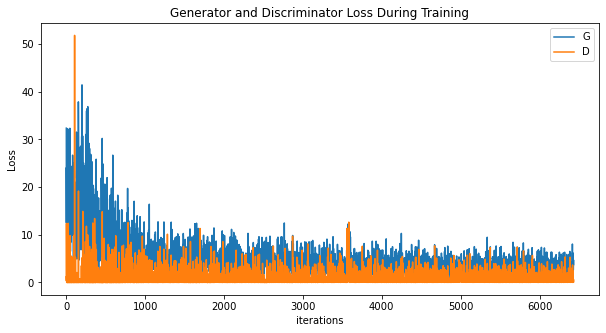

In [110]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

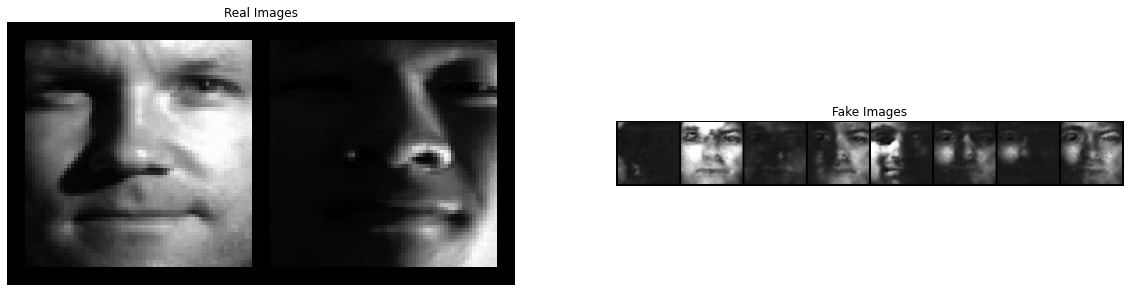

In [111]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

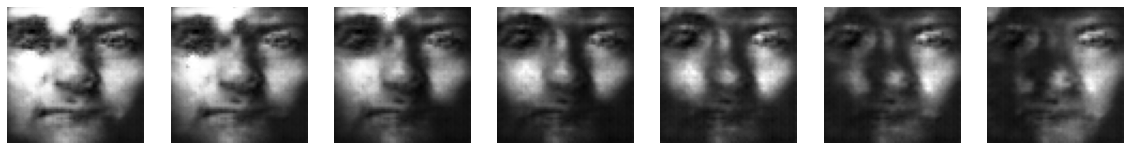

In [112]:
# Solution

nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
    w1 = i/(nsamples-1)
    w2 = 1-w1
    z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(20, 20))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    fake_image = np.transpose(images[i].detach().cpu(),(1,2,0))
    plt.imshow(fake_image, cmap="gray")
plt.show()